In [15]:
import numpy as np
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt
from pvlib.forecast import HRRR

In [16]:
def get_forecast_pvlib(lat, lon, start_time, final_time):

    # Weather forecast part 1
    forecaster = HRRR()
    query_variables = list(forecaster.variables.values())
    query_variables.remove('Temperature_height_above_ground')
    query_variables.remove('v-component_of_wind_height_above_ground')
    query_variables.remove('u-component_of_wind_height_above_ground')
    wf1 = forecaster.get_data(lat, lon, start_time, final_time, query_variables=query_variables)

    # Weather forecast part 2
    forecaster = HRRR()
    query_variables = ['Temperature_height_above_ground']
    wf2 = forecaster.get_data(lat, lon, start_time, final_time, query_variables=query_variables)

    return pd.concat([wf1, wf2], axis=1)

In [17]:

class weather_forecaster(object):

    def __init__(self, latitude=45.367584, longitude=-68.972168, tz='America/New_York',
                 irrad_vars=['ghi', 'dni', 'dhi'], horizon=24, model=HRRR):
        """
        Initialize for Maine
        Note: tz is for timezone
        """
        self.latitude = latitude
        self.longitude = longitude
        self.tz = tz
        self.irrad_vars = irrad_vars
        self.horizon = horizon
        self.forecaster = model()
        
    def get_forecast(self, start=None, end=None):

        # If no start time is provided, choose now (converted to specified timezone)
        if not start:
            start = dtm.datetime.utcnow().replace(minute=0, second=0, microsecond=0)
            self.start_dt = pd.Timestamp(start, tz='UTC').tz_convert(self.tz)
            print(f"\nCurrent UTC time: {start}")
            print(f"Current time in {self.tz}: {self.start_dt}\n") 
        # Otherwise read the provided start time
        else:
            self.start_dt = pd.Timestamp(start, tz=self.tz)
        
        # If no end time is provided, choose now + horizon
        if not end:
            self.end_dt = self.start_dt + pd.Timedelta(hours=self.horizon)
        # Otherwise read the provided end time
        else:
            self.end_dt = pd.Timestamp(end, tz=self.tz)
            
        # Get the forecast from pvlib
        self.forecast = get_forecast_pvlib(self.latitude, self.longitude, self.start_dt, self.end_dt)
        
        # Set the forecast of some columns to 0
        dummy_forecast_cols = ['wind_speed_u', 'wind_speed_v',
                       'Low_cloud_cover_low_cloud', 'Medium_cloud_cover_middle_cloud', 'High_cloud_cover_high_cloud',
                       'Pressure_surface', 'Wind_speed_gust_surface']
        for c in dummy_forecast_cols:
            self.forecast[c] = 0

        # Set the location
        self.forecaster.set_location(self.start_dt.tz, self.latitude, self.longitude)
        
        # Duplicate last beacuse of bug in pvlib
        self.forecast.loc[self.forecast.index[-1]+pd.DateOffset(hours=1), :] = self.forecast.iloc[-1]
        self.data = self.forecaster.process_data(self.forecast)
        self.data = self.data.loc[self.forecast.index[:-1]]
        self.data.index = self.data.index.tz_localize(None)
                              
        return list(self.data['temp_air'])

In [18]:

def get_weather(start, end):

    forecaster = weather_forecaster()
    
    T_OA = forecaster.get_forecast(start, end)
    print(T_OA) 
    
    plt.plot(T_OA)
    plt.title("Live outside air temperature forecast - HRRR")
    plt.xticks(list(range(len(T_OA))))
    plt.show()



[18.572357177734375, 17.4473876953125, 16.63934326171875, 16.432830810546875, 16.4991455078125, 16.568023681640625, 17.2918701171875, 19.087127685546875, 19.323150634765625, 20.206207275390625, 22.2486572265625, 23.63507080078125, 24.981781005859375, 25.85711669921875, 26.83172607421875, 27.72772216796875, 28.20819091796875, 28.517913818359375, 28.053009033203125, 26.68548583984375]


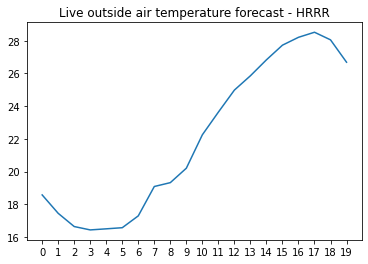

In [19]:
start = dtm.datetime(2024, 5, 22, 0, 0, 0)
end = dtm.datetime(2024, 5, 22, 19, 0, 0)

get_weather(start, end)


Current UTC time: 2024-05-23 00:00:00
Current time in America/New_York: 2024-05-22 20:00:00-04:00

[24.837890625, 23.52447509765625, 22.66680908203125, 21.300506591796875, 19.960479736328125, 18.792816162109375, 18.024383544921875, 17.30584716796875, 16.986053466796875, 16.623992919921875, 17.94512939453125, 20.396484375, 22.359527587890625, 19.97119140625, 22.1318359375, 23.485382080078125, 24.6768798828125]


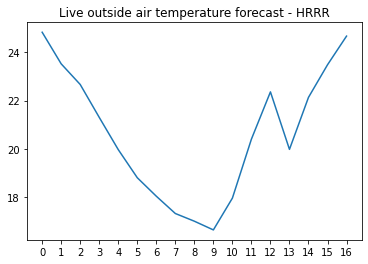

In [20]:
get_weather(None, None)